In [3]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

2024-09-02 11:13:24.290494: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 11:13:24.293896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 11:13:24.350537: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 11:13:24.356655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 11:13:25.329874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [12]:
df = pd.read_csv('SMD_Dataset/machine.csv')

## Quick look at data

In [13]:
df.head()

,cpu_r,load_1,load_5,load_15,mem_shmem,mem_u,mem_u_e,total_mem,disk_q,disk_r,...,out_rsts,out_segs,passive_opens,retransegs,tcp_timeouts,udp_in_dg,udp_out_dg,udp_rcv_buf_errs,udp_snd_buf_errs,label
0,0.075269,0.065678,0.070234,0.074332,0,0.933333,0.274011,0,0.031081,0.000000,...,0.008596,0.068036,0.048893,0.000386,0.000034,0.064432,0.064500,0,0,0
1,0.086022,0.080508,0.075808,0.076655,0,0.930769,0.274953,0,0.031081,0.000122,...,0.008596,0.070020,0.050437,0.000386,0.000022,0.065228,0.065224,0,0,0
2,0.075269,0.064619,0.071349,0.074332,0,0.928205,0.274953,0,0.030940,0.000366,...,0.008596,0.069684,0.055069,0.000386,0.000045,0.067111,0.067178,0,0,0
3,0.086022,0.048729,0.063545,0.070848,0,0.928205,0.273070,0,0.027250,0.000244,...,0.010029,0.073253,0.051467,0.000000,0.000034,0.066676,0.066744,0,0,0
4,0.086022,0.051907,0.062430,0.070848,0,0.933333,0.274011,0,0.030940,0.000244,...,0.008596,0.070932,0.051467,0.000386,0.000022,0.066604,0.066671,0,0,0


In [14]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['cpu_r', 'load_1', 'load_5', 'load_15', 'mem_u', 'mem_u_e',
       'disk_q', 'disk_r', 'disk_rb', 'disk_svc', 'disk_u',
       'disk_w', 'disk_wa', 'disk_wb', 'eth1_fi', 'eth1_f0',
       'eth1_pi', 'eth1_p0', 'tcp_tw', 'tcp_use', 'active_opens', 'curr_estab',
       'in_segs', 'listen_overflows', 'out_rsts', 'out_segs',
       'passive_opens', 'retransegs', 'tcp_timeouts', 'udp_in_dg',
       'udp_out_dg']]

In [15]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15499 entries, 0 to 15498
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cpu_r             15499 non-null  float64
 1   load_1            15499 non-null  float64
 2   load_5            15499 non-null  float64
 3   load_15           15499 non-null  float64
 4   mem_u             15499 non-null  float64
 5   mem_u_e           15499 non-null  float64
 6   disk_q            15499 non-null  float64
 7   disk_r            15499 non-null  float64
 8   disk_rb           15499 non-null  float64
 9   disk_svc          15499 non-null  float64
 10  disk_u            15499 non-null  float64
 11  disk_w            15499 non-null  float64
 12  disk_wa           15499 non-null  float64
 13  disk_wb           15499 non-null  float64
 14  eth1_fi           15499 non-null  float64
 15  eth1_f0           15499 non-null  float64
 16  eth1_pi           15499 non-null  float6

In [16]:
data = df.to_numpy()

In [17]:
data.shape

(15499, 31)

In [18]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    Xs.append(data[i:i+window_size,:])
    #Ys.append(data[i+window_size,:]) # For multi target variables
    Ys.append(data[i+window_size,:][0]) # For single target variable
  return np.array(Xs), np.array(Ys)

In [19]:
TIME_STEPS = 5

In [20]:
X_train, Y_train= generate_sequences(data, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training output shape: ", Y_train.shape)

Training input shape:  (15494, 5, 31)
Training output shape:  (15494,)


In [21]:
X_train[0]

array([[7.52690e-02, 6.56780e-02, 7.02340e-02, 7.43320e-02, 9.33333e-01,
        2.74011e-01, 3.10810e-02, 0.00000e+00, 1.34132e-01, 8.10810e-02,
        2.73970e-02, 6.78080e-02, 1.25842e-01, 1.50562e-01, 1.21988e-01,
        9.19780e-02, 9.39600e-02, 7.41550e-02, 9.35405e-01, 1.80770e-02,
        3.20100e-02, 1.65840e-02, 7.77020e-02, 0.00000e+00, 8.59600e-03,
        6.80360e-02, 4.88930e-02, 3.86000e-04, 3.40000e-05, 6.44320e-02,
        6.45000e-02],
       [8.60220e-02, 8.05080e-02, 7.58080e-02, 7.66550e-02, 9.30769e-01,
        2.74953e-01, 3.10810e-02, 1.22000e-04, 1.48813e-01, 1.62162e-01,
        5.47950e-02, 7.13950e-02, 1.23068e-01, 1.64490e-01, 1.21396e-01,
        9.41620e-02, 9.61600e-02, 7.64820e-02, 9.96555e-01, 1.60260e-02,
        3.35840e-02, 1.47350e-02, 7.93960e-02, 0.00000e+00, 8.59600e-03,
        7.00200e-02, 5.04370e-02, 3.86000e-04, 2.20000e-05, 6.52280e-02,
        6.52240e-02],
       [7.52690e-02, 6.46190e-02, 7.13490e-02, 7.43320e-02, 9.28205e-01,
       

In [75]:
Y_train.shape

(15494,)

In [76]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

In [92]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(rate=0.1))
#model.add(Dense(X_train.shape[2])) # For multi target variables
model.add(Dense(1))  # For single target variable
model.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 128)            81920     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 131,393
Trainable params: 131,393
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [93]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                    shuffle=False)

Epoch 1/30
388/388 [==============================] - 9s 17ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 2/30
388/388 [==============================] - 6s 16ms/step - loss: 2.8490e-04 - val_loss: 7.5406e-04
Epoch 3/30
388/388 [==============================] - 6s 16ms/step - loss: 1.9905e-04 - val_loss: 8.5818e-04
Epoch 4/30
388/388 [==============================] - 6s 16ms/step - loss: 1.4932e-04 - val_loss: 7.6989e-04
Epoch 5/30
388/388 [==============================] - 6s 16ms/step - loss: 1.6347e-04 - val_loss: 6.2147e-04
Epoch 6/30
388/388 [==============================] - 6s 16ms/step - loss: 1.3680e-04 - val_loss: 0.0010
Epoch 7/30
388/388 [==============================] - 6s 16ms/step - loss: 1.3461e-04 - val_loss: 2.0018e-04
Epoch 8/30
388/388 [==============================] - 6s 15ms/step - loss: 1.3041e-04 - val_loss: 4.7150e-04
Epoch 9/30
388/388 [==============================] - 6s 15ms/step - loss: 1.1673e-04 - val_loss: 7.3846e-04
Epoch 10/30
388/388 [==========

#### Plot Training - Validation loss

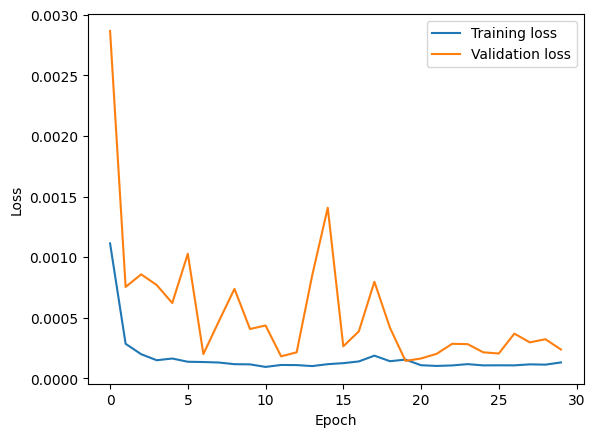

In [94]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [95]:
model.save('saved_models/lstm.h5')

In [4]:
new_df = pd.read_csv('SMD_Dataset/machine-anomaly.csv')

new_df = new_df[['cpu_r', 'load_1', 'load_5', 'load_15', 'mem_u', 'mem_u_e',
       'disk_q', 'disk_r', 'disk_rb', 'disk_svc', 'disk_u',
       'disk_w', 'disk_wa', 'disk_wb', 'eth1_fi', 'eth1_f0',
       'eth1_pi', 'eth1_p0', 'tcp_tw', 'tcp_use', 'active_opens', 'curr_estab',
       'in_segs', 'listen_overflows', 'out_rsts', 'out_segs',
       'passive_opens', 'retransegs', 'tcp_timeouts', 'udp_in_dg',
       'udp_out_dg']]


In [5]:
import shap
import tensorflow as tf
user_model = tf.keras.models.load_model('saved_models/lstm.h5')

/home/giri/anaconda3/envs/aioenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/giri/anaconda3/envs/aioenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

In [10]:
new_data = new_df.to_numpy()
X_new, Y_new = generate_sequences(new_data, TIME_STEPS)
new_test_pred = user_model.predict(X_new, verbose=1)

 71/406 [====>.........................] - ETA: 2s

406/406 [==============================] - 3s 7ms/step


In [22]:
explainer = shap.GradientExplainer(user_model, X_train)
shap_values = explainer.shap_values(X_new)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [23]:
for val in shap_values:
    print(type(val))
    print('----------')

<class 'numpy.ndarray'>
----------


In [24]:
print(shap_values[0].shape) # Close Price
# print(shap_values[1].shape) # Volume
print(len(shap_values))
print(X_new.shape)

(12974, 5, 31)
1
(12974, 5, 31)


In [25]:
last_idx_arr = []
for item in shap_values[0]:
    #print(item[-1])
    last_idx_arr.append(item[-1])
last_idx_arr = np.array(last_idx_arr)
print(last_idx_arr.shape)

(12974, 31)


In [26]:
features = ['cpu_r', 'load_1', 'load_5', 'load_15', 'mem_u', 'mem_u_e',
       'disk_q', 'disk_r', 'disk_rb', 'disk_svc', 'disk_u',
       'disk_w', 'disk_wa', 'disk_wb', 'eth1_fi', 'eth1_f0',
       'eth1_pi', 'eth1_p0', 'tcp_tw', 'tcp_use', 'active_opens', 'curr_estab',
       'in_segs', 'listen_overflows', 'out_rsts', 'out_segs',
       'passive_opens', 'retransegs', 'tcp_timeouts', 'udp_in_dg',
       'udp_out_dg']
res_df = pd.DataFrame(last_idx_arr, columns=features)
print(len(res_df))
print(res_df.shape)

12974
(12974, 31)


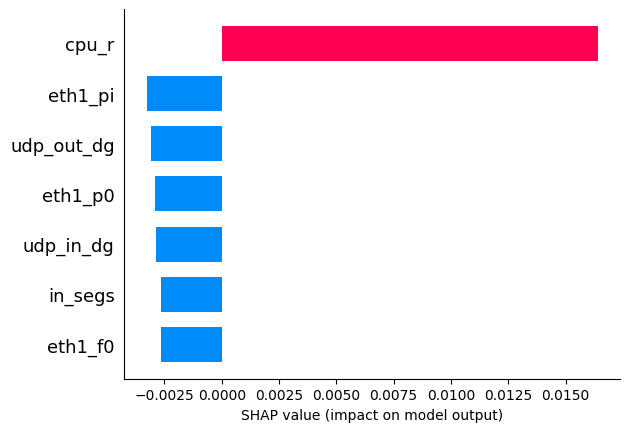

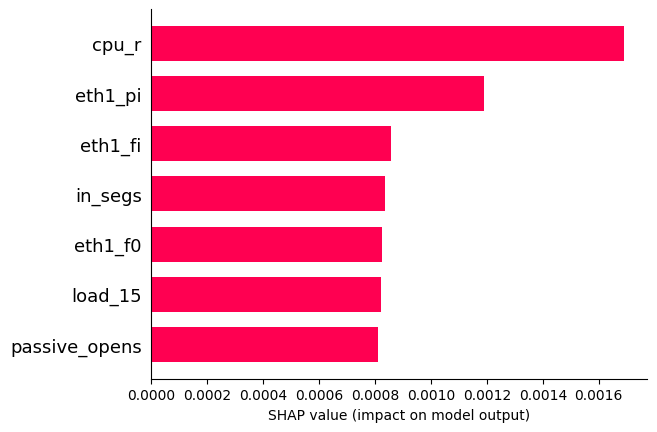

In [36]:
shap.bar_plot(res_df.iloc[400], feature_names=features)
shap.bar_plot(res_df.iloc[0], feature_names=features)

In [37]:
new_data_df = pd.DataFrame(new_data[TIME_STEPS:], columns=features)

In [38]:
last_idx_arr.shape

(12974, 31)

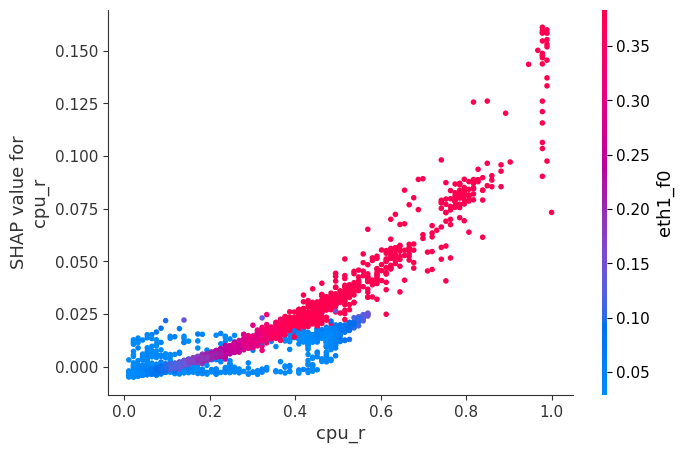

In [34]:
shap.dependence_plot(0, last_idx_arr, new_data[TIME_STEPS:], feature_names=features) 
#shap.dependence_plot(1, last_idx_arr2, scaled_new_test[TIME_STEPS:]) 

In [43]:
last_idx_arr[0:300].shape

(300, 31)

In [44]:
new_data[TIME_STEPS:][0:300].shape

(300, 31)

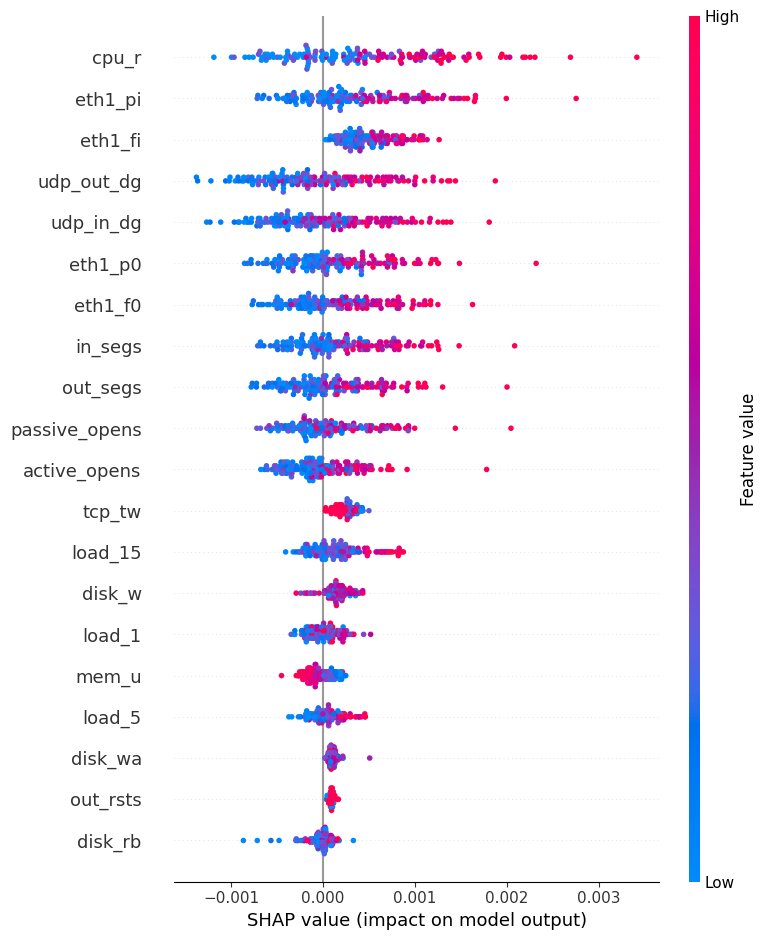

In [47]:
shap.summary_plot(last_idx_arr[0:150],new_data[TIME_STEPS:][0:150], feature_names=features) #Close Price
#shap.summary_plot(last_idx_arr2, scaled_new_test[TIME_STEPS:]) #Volume

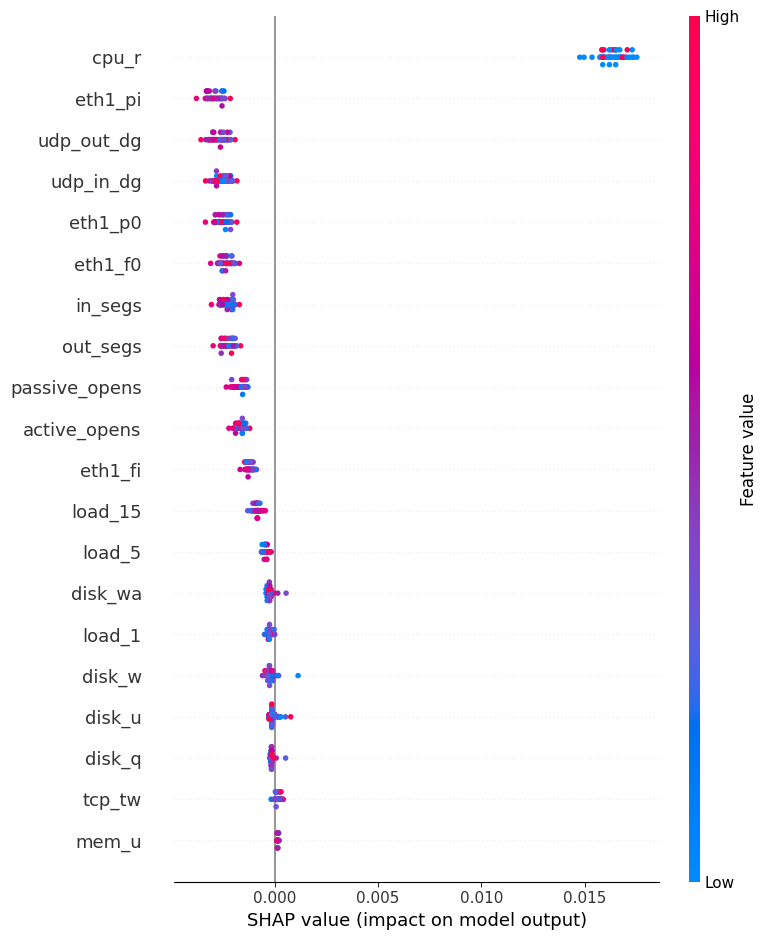

In [48]:
shap.summary_plot(last_idx_arr[400:450],new_data[TIME_STEPS:][400:450], feature_names=features) #Close Price